# 刺激

本部分将介绍如何生成刺激并将刺激应用到数字孪生脑仿真中。刺激是一个关于时间的函数，任意时刻的刺激值将按照空间分布作用到某空间（如图谱所定义的脑区空间）。[Stimulus](zjb.main.simulation.stimulus.Stimulus)是定义刺激的基类，继承该类并实现`make_time_func`函数即可自定义刺激。在刺激模块中，已经实现了一些类以快速生成常用的刺激。

## 使用内置类生成刺激
### （单）脉冲刺激
[PulseStimulus](zjb.main.simulation.stimulus.PulseStimulus)用于生成具有单个脉冲的刺激。

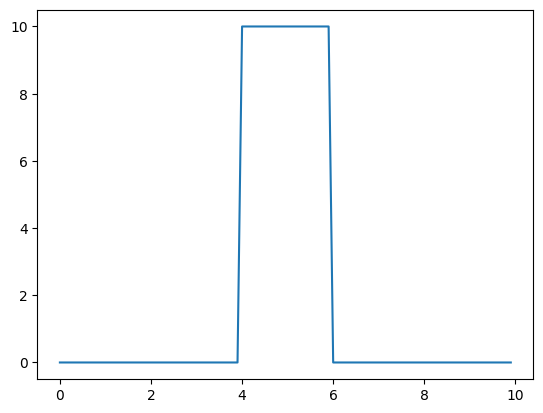

In [1]:
# 从API中导入脉冲刺激类
from zjb.main.api import PulseStimulus
from matplotlib import pyplot as plt

# 实例化一个脉冲刺激，脉冲强度为10, 起始时间4, 脉冲宽度2
stimulus = PulseStimulus(amp=10, start=4, width=2)
# 获取生成刺激的函数，该函数的输入为时间，输出为该时刻的刺激强度
func = stimulus.numba_func
# 创建间隔0.1,100个时间点的列表
ts = [0.1 * i for i in range(100)]
# 计算每个时刻的刺激值
ss = [func(t) for t in ts]
# 绘制刺激
plt.plot(ts, ss)
plt.show()

```{note}
脉冲包含起始时刻，不包含终止时刻。例如起始时刻为1, 宽度为1的刺激，脉冲时间为大于等于1，小于2
```
```{note}
每次获取刺激实例的`numba_func`时都可能会生成新的Numba函数。因此在不修改实例参数的情况下，不要多次调用`stimulus.numba_func`，这可能会产生极大的编译开销。内置的刺激类大多实现了`numba_func`属性的缓存，在不修改参数的情况下不会生成新的Numba函数，但仍然建议不要多次调用`stimulus.numba_func`。
```

### N周期脉冲刺激
[NCyclePulseStimulus](zjb.main.simulation.stimulus.NCyclePulseStimulus)用于生成具有多个（固定周期）脉冲的刺激

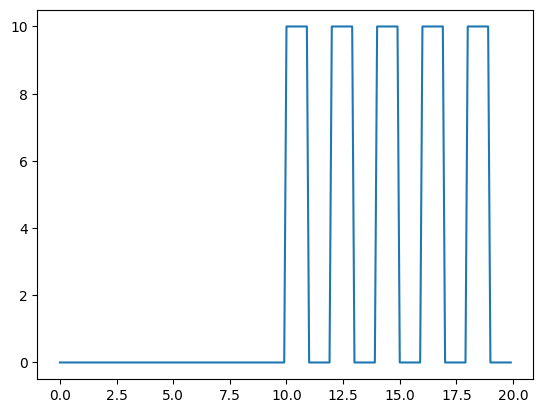

In [2]:
from zjb.main.api import NCyclePulseStimulus
from matplotlib import pyplot as plt

# 实例化一个连续的周期脉冲刺激，脉冲强度为10, 起始时刻为10，脉冲宽度为1, 脉冲周期为2
stimulus = NCyclePulseStimulus(amp=10, start=10, width=1, period=2, count=0)
func = stimulus.numba_func

ts = [0.1 * i for i in range(200)]
ss = [func(t) for t in ts]

plt.plot(ts, ss)
plt.show()

### 自定义脉冲刺激

[CustomPulseStimulus](zjb.main.simulation.stimulus.CustomPulseStimulus)用于生成由多个任意形状的脉冲组成的自定义脉冲刺激，其中每个自定义脉冲包括起始时间，终止时间和脉冲强度三个参数构成。 

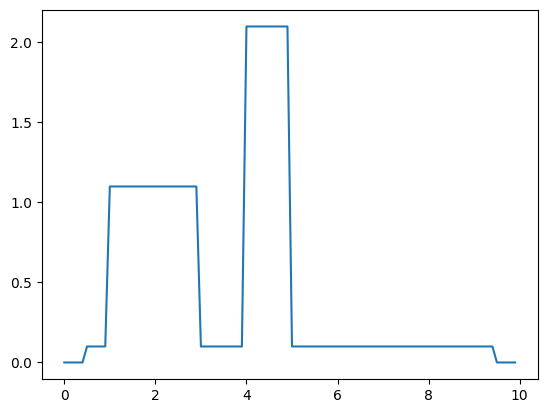

In [3]:
from zjb.main.api import CustomPulseStimulus
from matplotlib import pyplot as plt

# 实例化一个由3个脉冲组成的自定义脉冲刺激
stimulus = CustomPulseStimulus(series=[[1, 3, 1], [4, 5, 2], [0.5, 9.5, 0.1]])
func = stimulus.numba_func

ts = [0.1 * i for i in range(100)]
ss = [func(t) for t in ts]

plt.plot(ts, ss)
plt.show()

### 正弦刺激

[SinusoidStimulus](zjb.main.simulation.stimulus.SinusoidStimulus)用于生成形如$amp * \sin(2 \pi * freq * t + phase) + offset$的正弦刺激。

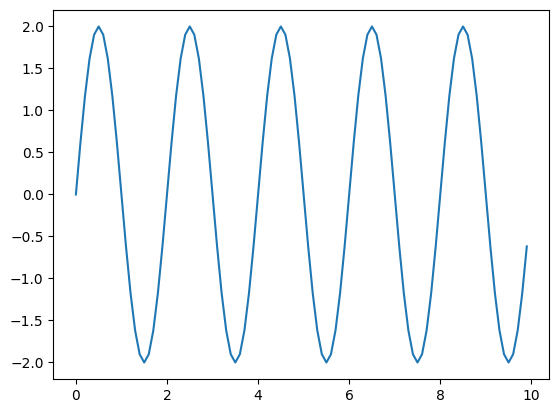

In [4]:
from zjb.main.api import SinusoidStimulus
from matplotlib import pyplot as plt

stimulus = SinusoidStimulus(amp=2, freq=0.5, phase=0, offset=0)
func = stimulus.numba_func

ts = [0.1 * i for i in range(100)]
ss = [func(t) for t in ts]

plt.plot(ts, ss)
plt.show()

### 高斯刺激

[GaussianStimulus](zjb.main.simulation.stimulus.GaussianStimulus)用于生成形如$amp * \exp(- \left(x - \mu\right) ^ 2 / \left(2 \sigma^2\right)) + offset$的钟形刺激。

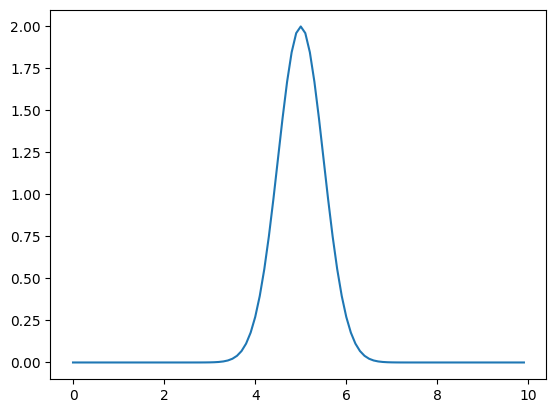

In [5]:
from zjb.main.api import GaussianStimulus
from matplotlib import pyplot as plt

stimulus = GaussianStimulus(amp=2, mu=5, sigma=0.5, offset=0)
func = stimulus.numba_func

ts = [0.1 * i for i in range(100)]
ss = [func(t) for t in ts]

plt.plot(ts, ss)
plt.show()

### 空间异质的刺激

以上生成的刺激都是标量值，但是所有的刺激实例都可以通过设置刺激实例的`space`属性为空间分布的向量值，生成具有空间异质性的向量刺激。

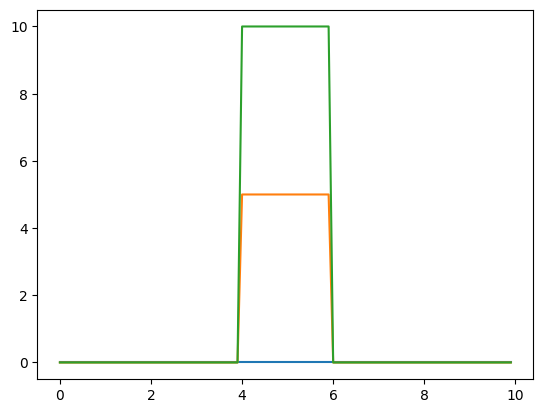

In [6]:
from zjb.main.api import PulseStimulus
from matplotlib import pyplot as plt

stimulus = PulseStimulus(space=[0, 0.5, 1], amp=10, start=4, width=2)
func = stimulus.numba_func

ts = [0.1 * i for i in range(100)]
ss = [func(t) for t in ts]

plt.plot(ts, ss)
plt.show()

## 在数字孪生脑仿真中使用刺激

数字孪生脑模型与数字孪生脑的参数值都支持设置为刺激实例，至少可以在3处设置参数值为刺激，根据实际情况选择其一即可。

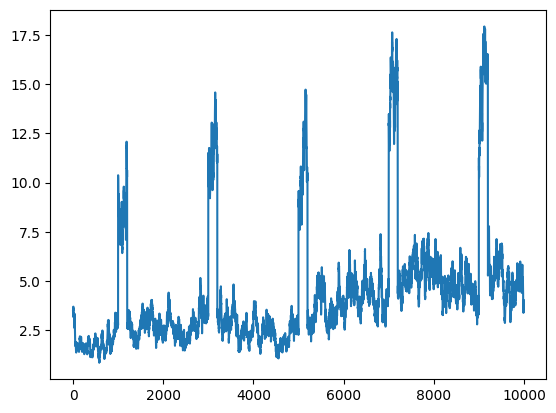

In [7]:
from zjb.main.api import (
    DynamicsModel,
    DTBModel,
    Subject,
    DTB,
    RegionalConnectivity,
    Atlas,
    Raw,
    EulerSolver,
    NCyclePulseStimulus,
)
from matplotlib import pyplot as plt

dynamics = DynamicsModel.from_name("ReducedWongWangExcInh")
atlas = Atlas(labels=["1"])

stimulus = NCyclePulseStimulus(amp=0.05, start=100, width=20, period=200)
model = DTBModel(
    dynamics=dynamics,
    atlas=atlas,
    solver=EulerSolver(noises={"S_e": 0.005, "S_i": 0.005}),
    monitors=[Raw(expression="r_e")],
    parameters={"I_ext": stimulus},  # 1. 在数字孪生脑模型中设置I_ext为脉冲刺激
)
conn = RegionalConnectivity(data=[[0.0]], space=atlas.space)
subject = Subject(data={"SC": conn})
dtb = DTB(
    subject=subject,
    model=model,
    connectivity=conn,
    # parameters={"I_ext": stimulus},  # 2. 在数字孪生脑中设置I_ext为脉冲刺激
)

result = dtb.simulate(
    t=1000,
    # dynamic_parameters={"I_ext": stimulus}, # 3. 在仿真时设置I_ext为脉冲刺激
)
ts = result.data[0]
plt.plot(ts.data)
plt.show()

## 自定义刺激类

当内置的刺激不满足需求时，可以通过自定义刺激类来实现具有任意时间模式的刺激，只需要实现一个`make_time_func`函数即可。

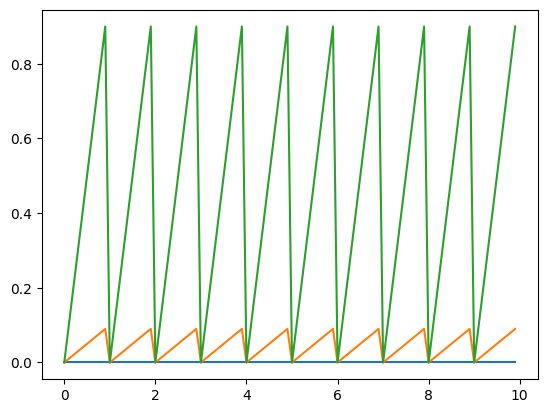

In [8]:
from numba import njit
from zjb.main.api import Stimulus
from matplotlib import pyplot as plt


class MyStimulus(Stimulus):
    def make_time_func(self):
        @njit(inline="always")
        def func(t):
            # 在这里实现自定义的刺激值关于时间的函数
            return t % 1

        return func


# 自定义的刺激也可以使用`space`属性设置异质的空间分布
stimulus = MyStimulus(space=[0, 0.1, 1])
func = stimulus.numba_func

ts = [0.1 * i for i in range(100)]
ss = [func(t) for t in ts]

plt.plot(ts, ss)
plt.show()